In [1]:
%pip install tensorflow==2.15.0 matplotlib tensorflowjs h5py kagglehub split-folders tensorflow-text==2.15.0 dopamine-rl==4.0.7 thinc==8.2.3 grpcio-status~=1.59.0 grpcio~=1.59.0 protobuf~=4.25.0 numpy~=1.26.4 tf-keras~=2.15.0 packaging~=23.2 tensorflow-decision-forests==1.8.1 spacy==3.7.5 google-cloud-bigquery~=3.17.0 --upgrade --no-cache-dir

In [2]:
# ==============================================================================
# Stage 0: Setup & Imports (Asumsi library sudah terinstall)
# ==============================================================================
print("Stage 0: Setup & Imports")
import os
import shutil
import random
import math
import logging
import sys
import zipfile

# --- Langsung ke Impor ---
print("\nMencoba mengimpor library utama...")
try:
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt
    import kagglehub
    import splitfolders
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

    # Validasi Versi (Opsional)
    TF_VERSION_REQUIRED = "2.15.0"
    print(f"Versi TensorFlow yang digunakan: {tf.__version__}")
    if tf.__version__ != TF_VERSION_REQUIRED:
         print(f"PERINGATAN: Versi TF ({tf.__version__}) tidak sesuai dengan yang diharapkan ({TF_VERSION_REQUIRED}). Pastikan instalasi manual berhasil.")
    print(f"Versi NumPy yang digunakan: {np.__version__}")

    print("Import berhasil.")
    print("\nStage 0 Selesai.")

except ImportError as e:
    print(f"\nERROR: Gagal mengimpor library: {e}")
    print("Pastikan Anda sudah menjalankan perintah 'pip install' yang diperlukan di lingkungan Anda.")
    sys.exit("Eksekusi dihentikan karena gagal impor.")
except Exception as e:
    print(f"\nERROR saat impor: {e}")
    sys.exit("Eksekusi dihentikan.")

Stage 0: Setup & Imports

Mencoba mengimpor library utama...
Versi TensorFlow yang digunakan: 2.15.0
Versi NumPy yang digunakan: 1.26.4
Import berhasil.

Stage 0 Selesai.


In [3]:
# ==============================================================================
# Stage 1: Konfigurasi Dasar
# ==============================================================================
# (Sama seperti sebelumnya - Konfigurasi Path, Parameter, Variabel Awal)
print("\nStage 1: Konfigurasi Dasar")
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
print(f"Ukuran Gambar: ({IMG_HEIGHT}, {IMG_WIDTH}), Batch Size: {BATCH_SIZE}")
OUTPUT_SPLIT_DIR = "/content/padangfood_split"
SPLIT_RATIO = (0.8, 0.1, 0.1)
SPLIT_SEED = 42
print(f"Output Split: {OUTPUT_SPLIT_DIR}, Rasio: {SPLIT_RATIO}")
INITIAL_EPOCHS = 25
FINE_TUNE_EPOCHS = 15
FINE_TUNE_LR = 1e-5
FINE_TUNE_THRESHOLD = 0.90
print(f"Epochs Awal: {INITIAL_EPOCHS}, Epochs Fine-tune: {FINE_TUNE_EPOCHS}, Fine-tune LR: {FINE_TUNE_LR}")
MODEL_SAVE_FILENAME = 'final_padangfood_model.keras'
MODEL_SAVE_PATH = f'/content/{MODEL_SAVE_FILENAME}'
CLASS_NAMES_FILE = '/content/class_names.txt'
print(f"Path Simpan Model: {MODEL_SAVE_PATH}")
print(f"Path File Kelas: {CLASS_NAMES_FILE}")
dataset_base_path = None
train_dir_split = os.path.join(OUTPUT_SPLIT_DIR, 'train')
val_dir_split = os.path.join(OUTPUT_SPLIT_DIR, 'val')
test_dir_split = os.path.join(OUTPUT_SPLIT_DIR, 'test')
train_generator, validation_generator, test_generator = None, None, None
num_classes, class_indices, class_names_by_indices, class_names = None, None, None, None
model, history, history_fine = None, None, None


Stage 1: Konfigurasi Dasar
Ukuran Gambar: (224, 224), Batch Size: 32
Output Split: /content/padangfood_split, Rasio: (0.8, 0.1, 0.1)
Epochs Awal: 25, Epochs Fine-tune: 15, Fine-tune LR: 1e-05
Path Simpan Model: /content/final_padangfood_model.keras
Path File Kelas: /content/class_names.txt


In [4]:
# ==============================================================================
# Stage 2: Akuisisi, Staging, Statistik & Struktur Awal Dataset
# ==============================================================================
print("\nStage 2: Akuisisi, Staging, Statistik & Struktur Awal Dataset")

# --- Fungsi Helper (Definisi display_statistics & display_folder_structure tetap sama) ---
# Pastikan definisi fungsi ini ada dari kode sebelumnya atau salin lagi ke sini jika perlu
def count_images(directory):
    stats = {}; total_images = 0
    if not os.path.isdir(directory): return stats, total_images
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = sum(1 for fname in os.listdir(class_path) if fname.lower().endswith(('.png','.jpg','.jpeg')) and os.path.isfile(os.path.join(class_path, fname)))
            stats[class_name] = count; total_images += count
    return stats, total_images

def display_statistics(directory, title="Dataset Statistics"):
    print(f"\n--- {title} ({directory}) ---")
    stats, total = count_images(directory)
    if not stats: print("  Tidak dapat menghitung statistik."); return
    max_len = max(len(k) for k in stats.keys()) if stats else 0
    for class_name, count in stats.items(): print(f"  {class_name:<{max_len}} : {count} images")
    print(f"  {'-'*(max_len+16)}")
    print(f"  {'Total':<{max_len}} : {total} images")
    print("-" * (max_len + 20))

def display_folder_structure(root_dir, title="Folder Structure", max_depth=2, max_files=3):
    print(f"\n--- {title} ({root_dir}) ---")
    if not os.path.isdir(root_dir): print("  Direktori tidak ditemukan."); return
    start_level = root_dir.count(os.sep)
    for root, dirs, files in os.walk(root_dir):
        level = root.count(os.sep) - start_level
        if level > max_depth: dirs[:] = []; continue # Optimasi: stop os.walk masuk lebih dalam
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        img_files = [f for f in files if f.lower().endswith(('.png','.jpg','.jpeg'))]
        for i, f in enumerate(img_files):
            if i < max_files: print(f"{sub_indent}{f}")
            else: print(f"{sub_indent}... ({len(img_files) - max_files} more image files)"); break
    print("-" * 30)

# --- Akuisisi & Staging ---
dataset_base_path = None # Reset
staging_target_dir = '/content/padangfood_staged' # Target writable

try:
    print("Mencari path dataset PadangFood via Kaggle Hub...")
    download_path = kagglehub.dataset_download("faldoae/padangfood")
    print(f"Path dataset sumber (read-only): {download_path}") # e.g., /kaggle/input/padangfood

    # *** PERBAIKAN KUNCI ADA DI SINI ***
    # Identifikasi sumber data aktual yang berisi folder kelas
    # Berdasarkan output Anda, folder kelas ada di dalam 'dataset_padang_food'
    actual_data_source = os.path.join(download_path, 'dataset_padang_food')
    print(f"Path sumber data aktual (berisi kelas): {actual_data_source}")

    # Pastikan sumber data aktual ini ada
    if not os.path.exists(actual_data_source) or not os.path.isdir(actual_data_source):
         raise FileNotFoundError(f"Direktori sumber data aktual '{actual_data_source}' tidak ditemukan di dalam '{download_path}'.")

    # Tentukan target staging
    print(f"Target direktori staging (writable): {staging_target_dir}")

    # Hapus target lama jika ada
    if os.path.exists(staging_target_dir):
        print(f"Menghapus direktori staging lama: {staging_target_dir}")
        shutil.rmtree(staging_target_dir)

    # --- Salin ISI dari SUMBER AKTUAL ke TARGET ---
    # copytree(sumber_aktual, target) akan menyalin isi sumber_aktual ke target
    print(f"Menyalin isi dari '{actual_data_source}' ke '{staging_target_dir}'...")
    shutil.copytree(actual_data_source, staging_target_dir)
    print(f"Data berhasil disalin.")

    # Path dasar untuk tahap selanjutnya adalah direktori staging
    dataset_base_path = staging_target_dir
    print(f"Dataset base path diatur ke: {dataset_base_path}")

except Exception as e:
    print(f"Error pada Stage 2 (Akuisisi/Staging): {e}")
    dataset_base_path = None

# --- Statistik & Struktur Awal (dari direktori staging) ---
if dataset_base_path and os.path.exists(dataset_base_path):
    # Sekarang statistik dan struktur harus benar
    display_statistics(dataset_base_path, title="Statistik Dataset Staging Awal")
    display_folder_structure(dataset_base_path, title="Struktur Folder Staging Awal", max_depth=1, max_files=3) # Tampilkan 1 level (kelas)
else:
    print("Tidak bisa menampilkan statistik/struktur awal (path staging tidak valid).")


Stage 2: Akuisisi, Staging, Statistik & Struktur Awal Dataset
Mencari path dataset PadangFood via Kaggle Hub...
Path dataset sumber (read-only): /kaggle/input/padangfood
Path sumber data aktual (berisi kelas): /kaggle/input/padangfood/dataset_padang_food
Target direktori staging (writable): /content/padangfood_staged
Menyalin isi dari '/kaggle/input/padangfood/dataset_padang_food' ke '/content/padangfood_staged'...
Data berhasil disalin.
Dataset base path diatur ke: /content/padangfood_staged

--- Statistik Dataset Staging Awal (/content/padangfood_staged) ---
  ayam_goreng     : 107 images
  ayam_pop        : 113 images
  daging_rendang  : 104 images
  dendeng_batokok : 109 images
  gulai_ikan      : 111 images
  gulai_tambusu   : 103 images
  gulai_tunjang   : 119 images
  telur_balado    : 111 images
  telur_dadar     : 116 images
  -------------------------------
  Total           : 993 images
-----------------------------------

--- Struktur Folder Staging Awal (/content/padangfo

In [5]:
# ==============================================================================
# Stage 3: Splitting Data & Statistik Hasil Split
# ==============================================================================
print("\nStage 3: Splitting Data & Statistik Hasil Split")
split_successful = False
if dataset_base_path and os.path.exists(dataset_base_path) and splitfolders:
    data_source_dir = dataset_base_path
    if not os.path.exists(OUTPUT_SPLIT_DIR):
        print(f"Memulai splitting dari '{data_source_dir}' ke '{OUTPUT_SPLIT_DIR}'...")
        try:
            logging.basicConfig(level=logging.WARNING, format='%(levelname)s: %(message)s') # Kurangi Loglevel Splitfolder
            splitfolders.ratio(data_source_dir, output=OUTPUT_SPLIT_DIR, seed=SPLIT_SEED, ratio=SPLIT_RATIO, group_prefix=None, move=False)
            print(f"\nData berhasil di-split.")
            split_successful = True
        except Exception as e: print(f"\nError saat splitting: {e}")
    else:
        print(f"Direktori split '{OUTPUT_SPLIT_DIR}' sudah ada. Melewati splitting.")
        split_successful = True # Anggap sukses jika folder sudah ada

    # Verifikasi & Statistik Hasil Split
    if split_successful:
        if not (os.path.exists(train_dir_split) and os.path.exists(val_dir_split) and os.path.exists(test_dir_split)):
             print(f"Error: Folder train/val/test tidak lengkap di '{OUTPUT_SPLIT_DIR}'!")
             split_successful = False
        else:
             print("Verifikasi folder hasil split: OK")
             display_statistics(train_dir_split, title="Statistik Train Set")
             display_statistics(val_dir_split, title="Statistik Validation Set")
             display_statistics(test_dir_split, title="Statistik Test Set")
             # Tampilkan struktur folder hasil split
             display_folder_structure(OUTPUT_SPLIT_DIR, title="Struktur Folder Hasil Split", max_depth=2, max_files=1)
else:
    print("Splitting dibatalkan: dataset_base_path tidak valid atau library splitfolders tidak ada.")


Stage 3: Splitting Data & Statistik Hasil Split
Memulai splitting dari '/content/padangfood_staged' ke '/content/padangfood_split'...


Copying files: 993 files [00:00, 3905.59 files/s]


Data berhasil di-split.
Verifikasi folder hasil split: OK

--- Statistik Train Set (/content/padangfood_split/train) ---
  ayam_goreng     : 85 images
  ayam_pop        : 90 images
  daging_rendang  : 83 images
  dendeng_batokok : 87 images
  gulai_ikan      : 88 images
  gulai_tambusu   : 82 images
  gulai_tunjang   : 95 images
  telur_balado    : 88 images
  telur_dadar     : 92 images
  -------------------------------
  Total           : 790 images
-----------------------------------

--- Statistik Validation Set (/content/padangfood_split/val) ---
  ayam_goreng     : 10 images
  ayam_pop        : 11 images
  daging_rendang  : 10 images
  dendeng_batokok : 10 images
  gulai_ikan      : 11 images
  gulai_tambusu   : 10 images
  gulai_tunjang   : 11 images
  telur_balado    : 11 images
  telur_dadar     : 11 images
  -------------------------------
  Total           : 95 images
-----------------------------------

--- Statistik Test Set (/content/padangfood_split/test) ---
  ayam_gor


Stage 4: Preprocessing, Data Generators & Visualisasi
Menyiapkan ImageDataGenerator...
ImageDataGenerators dibuat.

Membuat Generator dari Direktori...
Found 790 images belonging to 9 classes.
Train generator: 790 gbr, 9 kelas.
Found 95 images belonging to 9 classes.
Validation generator: 95 gbr, 9 kelas.
Found 108 images belonging to 9 classes.
Test generator: 108 gbr, 9 kelas.

Class indices: {'ayam_goreng': 0, 'ayam_pop': 1, 'daging_rendang': 2, 'dendeng_batokok': 3, 'gulai_ikan': 4, 'gulai_tambusu': 5, 'gulai_tunjang': 6, 'telur_balado': 7, 'telur_dadar': 8}
Nama kelas disimpan ke: /content/class_names.txt

Visualisasi contoh batch training...


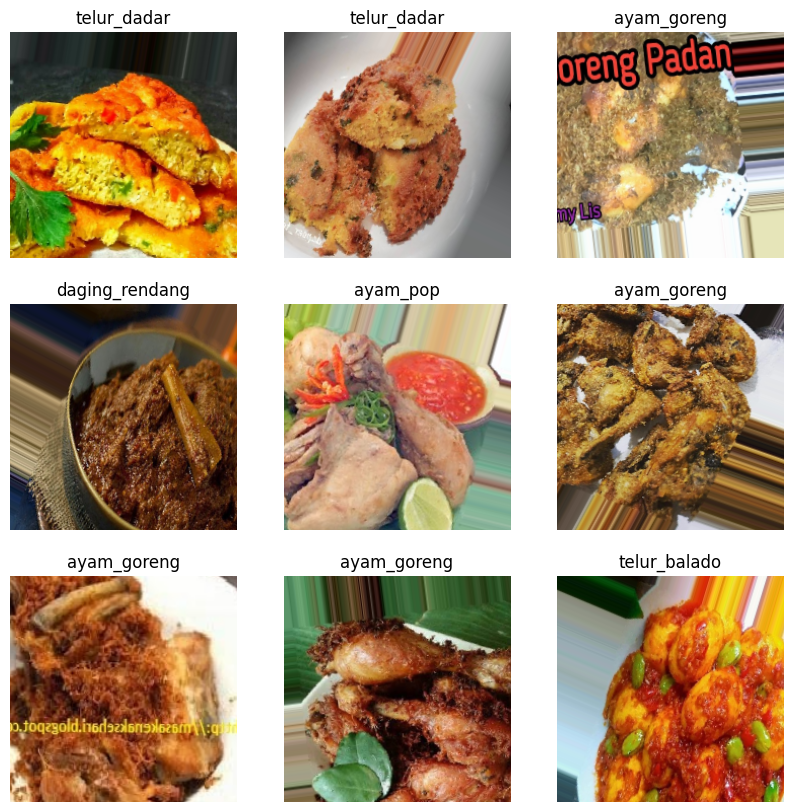

In [6]:
# ==============================================================================
# Stage 4: Preprocessing, Data Generators & Visualisasi
# ==============================================================================
print("\nStage 4: Preprocessing, Data Generators & Visualisasi")
generators_created = False
if split_successful: # Hanya jika split berhasil
    print("Menyiapkan ImageDataGenerator...")
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=25, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    print("ImageDataGenerators dibuat.")
    print("\nMembuat Generator dari Direktori...")
    try:
        train_generator = train_datagen.flow_from_directory(train_dir_split, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
        print(f"Train generator: {train_generator.samples} gbr, {train_generator.num_classes} kelas.")
        if num_classes is None: num_classes = train_generator.num_classes
        validation_generator = validation_datagen.flow_from_directory(val_dir_split, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
        print(f"Validation generator: {validation_generator.samples} gbr, {validation_generator.num_classes} kelas.")
        if os.path.exists(test_dir_split):
            test_generator = test_datagen.flow_from_directory(test_dir_split, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
            print(f"Test generator: {test_generator.samples} gbr, {test_generator.num_classes} kelas.")
        else: print("Test generator tidak dibuat (folder test tidak ada).")
        generators_created = True # Tandai generator berhasil dibuat
    except Exception as e: print(f"Error membuat generator: {e}")

    if generators_created and train_generator:
        try:
            class_indices = train_generator.class_indices
            class_names_by_indices = {v: k for k, v in class_indices.items()}
            class_names = list(class_names_by_indices.values())
            print("\nClass indices:", class_indices)
            with open(CLASS_NAMES_FILE, 'w') as f: [f.write(f"{class_names_by_indices.get(i, '')}\n") for i in range(len(class_names_by_indices))]
            print(f"Nama kelas disimpan ke: {CLASS_NAMES_FILE}")
        except Exception as e: print(f"Gagal simpan info kelas: {e}")

        # --- Visualisasi Batch ---
        print("\nVisualisasi contoh batch training...")
        def show_batch(img_batch, lbl_batch, cls_map):
            plt.figure(figsize=(10,10)); n_show=min(9,len(img_batch))
            for i in range(n_show):
                ax=plt.subplot(3,3,i+1); plt.imshow(img_batch[i])
                lbl_idx=np.argmax(lbl_batch[i]); plt.title(cls_map.get(lbl_idx,"Unk")); plt.axis("off")
            plt.show()
        if class_names_by_indices:
             try: img_batch_v, lbl_batch_v = next(train_generator); show_batch(img_batch_v, lbl_batch_v, class_names_by_indices)
             except Exception as e: print(f"Gagal visualisasi batch: {e}")
        else: print("Visualisasi dilewati (class map tidak ada).")
        # --- Akhir Visualisasi ---
    else: print("Pembuatan generator gagal.")
else: print("Preprocessing dibatalkan (splitting tidak berhasil).")

In [7]:
# ==============================================================================
# Stage 5: Membangun Model
# ==============================================================================
print("\nStage 5: Membangun Model")

# Hitung jumlah kelas dan cek generator
num_classes = len(class_names) if isinstance(class_names, (list, tuple)) else 0
# Generator dianggap valid jika train dan validation generator sudah dibuat
generators_created = (train_generator is not None and validation_generator is not None)

# Fungsi build transfer model
def build_transfer_model(input_shape, num_classes_local):
    if not isinstance(num_classes_local, int) or num_classes_local <= 0:
        raise ValueError("Jumlah kelas harus berupa integer positif.")
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False
    model_seq = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(num_classes_local, activation='softmax')
        ],
        name="PadangFood_MobileNetV2"
    )
    return model_seq

# Bangun model jika syarat terpenuhi
if num_classes > 0 and generators_created:
    try:
        model = build_transfer_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)
        print("Model berhasil dibangun.")
        model.summary()
    except ValueError as e:
        print(f"Error membangun model: {e}")
        model = None
else:
    print(f"Bangun model dibatalkan: num_classes={num_classes}, generators_created={generators_created}")
    model = None


Stage 5: Membangun Model
9406464/9406464 [==============================] - 0s 0us/step
Model berhasil dibangun.
Model: "PadangFood_MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 4617   

In [8]:
# ==============================================================================
# Stage 6: Initial Training
# ==============================================================================
print("\nStage 6: Initial Training")
if model and train_generator and validation_generator: # Cek semua prasyarat
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Model dikompilasi (LR=0.001).")
    checkpoint_initial = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    early_stopping_initial = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    print("Callbacks disiapkan.")
    print("Memulai initial training...")
    history = model.fit(train_generator, epochs=INITIAL_EPOCHS, validation_data=validation_generator, callbacks=[checkpoint_initial, early_stopping_initial])
    print("Initial training selesai.")
else: print("Initial training dibatalkan: prasyarat tidak terpenuhi."); history = None


Stage 6: Initial Training
Model dikompilasi (LR=0.001).
Callbacks disiapkan.
Memulai initial training...
Epoch 1/25
25/25 [==============================] - ETA: 0s - loss: 1.6580 - accuracy: 0.4329
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to /content/final_padangfood_model.keras
25/25 [==============================] - 44s 2s/step - loss: 1.6580 - accuracy: 0.4329 - val_loss: 0.6529 - val_accuracy: 0.8000
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.7658
Epoch 2: val_accuracy did not improve from 0.80000
25/25 [==============================] - 38s 2s/step - loss: 0.7353 - accuracy: 0.7658 - val_loss: 0.5194 - val_accuracy: 0.7684
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.8203
Epoch 3: val_accuracy improved from 0.80000 to 0.83158, saving model to /content/final_padangfood_model.keras
25/25 [==============================] - 38s 2s/step - loss: 0.5495 - accuracy: 0.8203


Stage 7: Initial Evaluation & Plotting
Plot disimpan ke: /content/initial_training_results.png


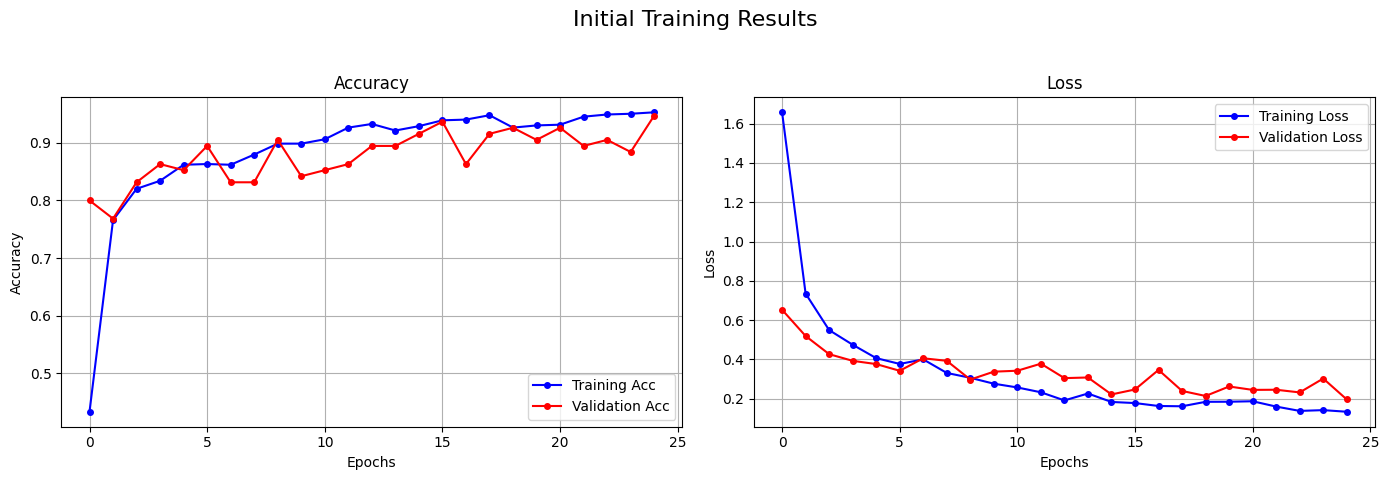


Eval (initial) Val Set...
  Val Loss: 0.1964, Val Accuracy: 0.9474
Eval (initial) Test Set...
4/4 [==============================] - 4s 894ms/step - loss: 0.2106 - accuracy: 0.9167
  Test Loss: 0.2106, Test Accuracy: 0.9167


In [9]:
# ==============================================================================
# Stage 7: Initial Evaluation & Plotting
# ==============================================================================
print("\nStage 7: Initial Evaluation & Plotting")
# (Kode plot_training_history sama seperti sebelumnya)
def plot_training_history(history_obj, title_prefix=""):
    if not history_obj or not history_obj.history: print("Error: Objek history tidak valid."); return
    required_keys = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    if not all(key in history_obj.history for key in required_keys): print(f"Error: Data history tidak lengkap. Keys: {list(history_obj.history.keys())}"); return
    acc,val_acc,loss,val_loss = [history_obj.history[k] for k in required_keys]
    epochs_range = range(len(acc))
    plt.figure(figsize=(14, 5)); plt.suptitle(f"{title_prefix} Training Results", fontsize=16)
    plt.subplot(1,2,1); plt.plot(epochs_range,acc,'bo-',label='Training Acc',ms=4); plt.plot(epochs_range,val_acc,'ro-',label='Validation Acc',ms=4); plt.title('Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(loc='lower right'); plt.grid(True)
    plt.subplot(1,2,2); plt.plot(epochs_range,loss,'bo-',label='Training Loss',ms=4); plt.plot(epochs_range,val_loss,'ro-',label='Validation Loss',ms=4); plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(loc='upper right'); plt.grid(True)
    plt.tight_layout(rect=[0,0.03,1,0.95]);
    try: plot_filename=f"/content/{title_prefix.lower().replace(' ','_')}_training_results.png"; plt.savefig(plot_filename); print(f"Plot disimpan ke: {plot_filename}")
    except Exception as e: print(f"Gagal simpan plot: {e}")
    plt.show()

if history: plot_training_history(history, title_prefix="Initial")

val_accuracy = 0.0; test_accuracy = 0.0 # Reset/default
if model and validation_generator: print("\nEval (initial) Val Set..."); val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0); print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
if model and test_generator: print("Eval (initial) Test Set..."); test_loss, test_accuracy = model.evaluate(test_generator, verbose=1); print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
else: print("Eval test set dilewati.")

In [10]:
# ==============================================================================
# Stage 10: Save Final Model (.keras format)
# ==============================================================================
print("\nStage 10: Save Final Model (.keras format)")
if model:
    try: model.save(MODEL_SAVE_PATH); print(f"Model final disimpan ke: {MODEL_SAVE_PATH}")
    except Exception as e: print(f"Error simpan model final: {e}")
else: print("Simpan model dibatalkan.")


Stage 10: Save Final Model (.keras format)
Model final disimpan ke: /content/final_padangfood_model.keras



Stage 11: Inference Example
Model '/content/final_padangfood_model.keras' dimuat untuk inferensi.
Memilih gambar contoh dari test set...
Dipilih 9 gambar.

Melakukan prediksi...
Plot inferensi disimpan.


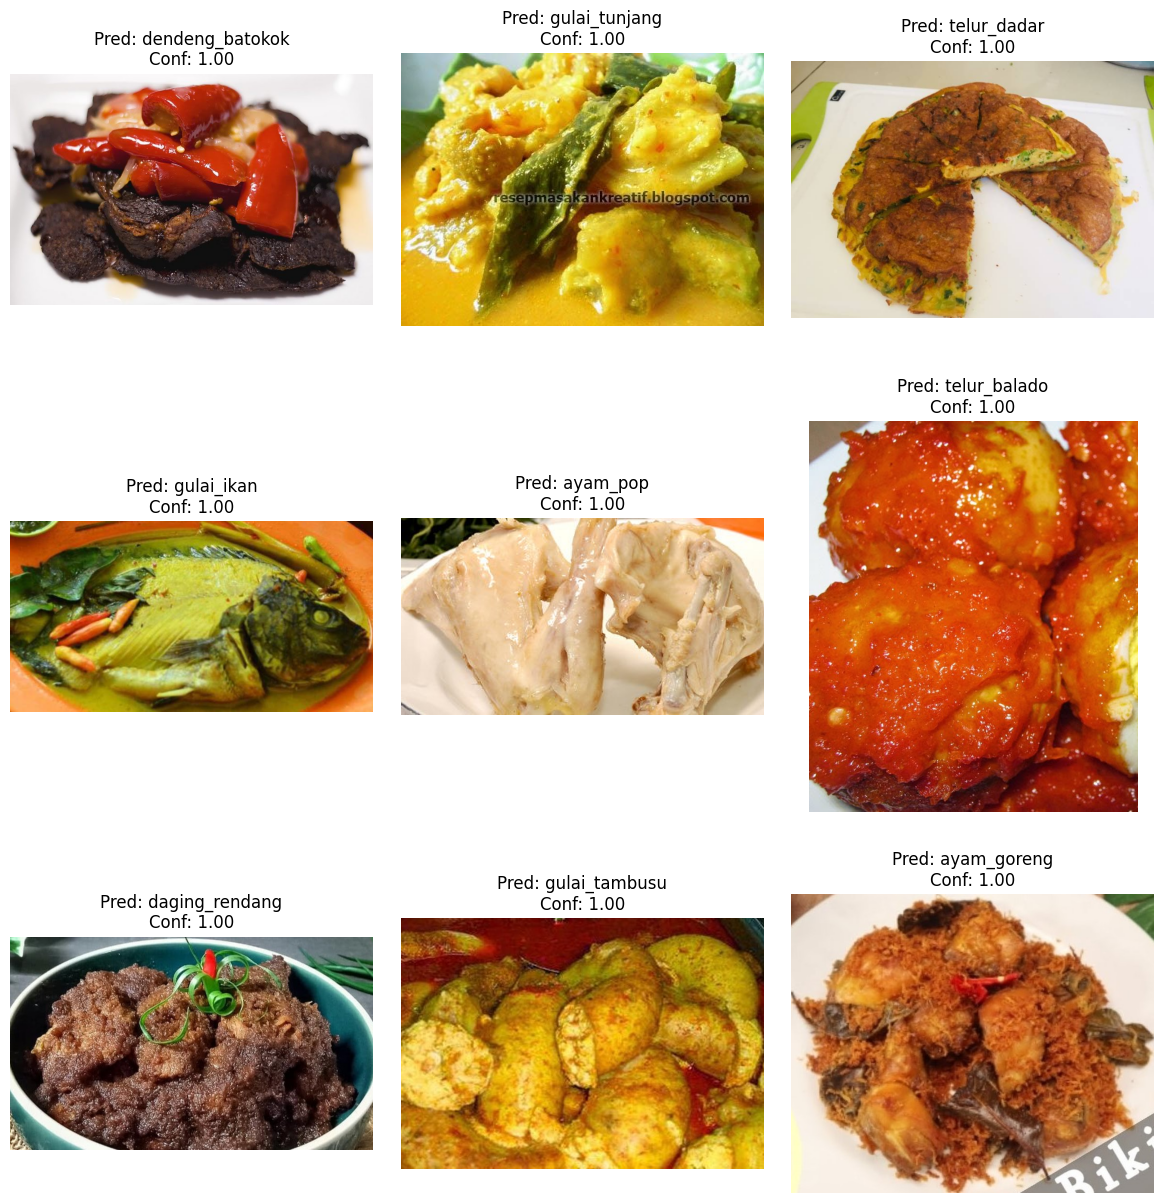


--- Workflow Selesai ---


In [11]:
# ==============================================================================
# Stage 11: Inference Example
# ==============================================================================
print("\nStage 11: Inference Example")
# (Kode fungsi preprocess_inference_image & predict_inference_image sama)
def preprocess_inference_image(ip, th=IMG_HEIGHT, tw=IMG_WIDTH):
    try: img=load_img(ip,target_size=(th,tw)); ia=img_to_array(img)/255.; ib=np.expand_dims(ia,axis=0); return ib
    except Exception as e: print(f"Err preprocess '{os.path.basename(ip)}': {e}"); return None
def predict_inference_image(ibp, im, cm):
    if ibp is None or im is None or cm is None: return "Error",0.0
    try: p=im.predict(ibp, verbose=0); pi=np.argmax(p[0]); c=p[0][pi]; cn=cm.get(pi,"Unk"); return cn,c # Set verbose=0 for predict
    except Exception as e: print(f"Err predict: {e}"); return "Pred Error",0.0

inference_model = None; inference_class_map = None
if os.path.exists(MODEL_SAVE_PATH):
    try: inference_model = load_model(MODEL_SAVE_PATH); print(f"Model '{MODEL_SAVE_PATH}' dimuat untuk inferensi.")
    except Exception as e: print(f"Error muat model inferensi: {e}")
if 'class_names_by_indices' in locals() and class_names_by_indices:
     inference_class_map = class_names_by_indices # Gunakan map yg sudah ada
elif os.path.exists(CLASS_NAMES_FILE): # Coba load jika belum ada
     try:
         with open(CLASS_NAMES_FILE, 'r') as f: loaded_cls = [l.strip() for l in f.readlines()]
         inference_class_map = {i:n for i,n in enumerate(loaded_cls)}; print(f"Class map diload dari {CLASS_NAMES_FILE}")
     except Exception as e: print(f"Error load class map: {e}")
else: print("Error: Class map tidak tersedia.")

test_images_for_inference = []
if test_dir_split and os.path.exists(test_dir_split) and inference_class_map:
    all_class_names_list = list(inference_class_map.values()) # Dapatkan list nama kelas dari map
    print("Memilih gambar contoh dari test set..."); num_classes_to_sample = min(len(all_class_names_list), 9)
    sampled_classes = random.sample(all_class_names_list, num_classes_to_sample)
    for cn in sampled_classes:
        cd = os.path.join(test_dir_split, cn)
        if os.path.isdir(cd):
            imgs = [f for f in os.listdir(cd) if f.lower().endswith(('.png','.jpg','.jpeg'))]
            if imgs: test_images_for_inference.append(os.path.join(cd, random.choice(imgs)))
    print(f"Dipilih {len(test_images_for_inference)} gambar.")

if inference_model and inference_class_map and test_images_for_inference:
    print("\nMelakukan prediksi...")
    num_img_inf=len(test_images_for_inference); cols_inf=min(3,num_img_inf); rows_inf=math.ceil(num_img_inf/cols_inf)
    plt.figure(figsize=(cols_inf*4, rows_inf*4+1))
    for i, img_path in enumerate(test_images_for_inference):
        img_batch = preprocess_inference_image(img_path)
        pred_class, pred_conf = predict_inference_image(img_batch, inference_model, inference_class_map)
        plt.subplot(rows_inf, cols_inf, i+1)
        try: img_disp=load_img(img_path); plt.imshow(img_disp); plt.title(f"Pred: {pred_class}\nConf: {pred_conf:.2f}")
        except Exception as e: plt.title(f"Pred: {pred_class}\nConf: {pred_conf:.2f}\n(Img Load Err)")
        plt.axis('off')
    plt.tight_layout(pad=2.0); plt.savefig('/content/inference_results.png'); print("Plot inferensi disimpan."); plt.show()
else: print("Inferensi dibatalkan: prasyarat tidak terpenuhi.")

print("\n--- Workflow Selesai ---")

In [13]:
# @title Kode Lengkap (v5) dengan Perbaikan InputLayer Dinamis & Download Otomatis Dikomentari
# -*- coding: utf-8 -*-
"""
Deskripsi:
Versi 5 (diperbarui): Otomatisasi konversi .keras (v3) -> .h5 -> TF.js,
dengan memastikan InputLayer dinamis sesuai model asli, dan menonaktifkan download otomatis.
"""

import os
import glob
import shutil
import time
import subprocess
import tensorflow as tf
# from google.colab import files  # Download otomatis dikomentari

print(f"--- Memulai Skrip Lengkap v5 (Keras->H5->TFJS) Diperbarui ({time.strftime('%A, %d %B %Y, ~%H:%M WIB')}) ---")
overall_start_time = time.time()

# --- Konfigurasi ---
IMG_HEIGHT = 150  # default jika diperlukan, tapi konversi akan baca m.input_shape
IMG_WIDTH  = 150  # default jika diperlukan
print("\n--- Tahap 0: Setup Awal & Konfigurasi ---")
setup_start_time = time.time()

# Path direktori
dir_root = '/content/'
dir_keras = os.path.join(dir_root, 'model_keras')
dir_tfjs  = os.path.join(dir_root, 'model_tfjs')
zip_base  = 'hasil_akhir_keras_h5_tfjs'
zip_path  = os.path.join(dir_root, f'{zip_base}.zip')
exclude_items = {'sample_data', '.config', f'{zip_base}.zip', 'padangfood_staged'}

# Buat direktori
os.makedirs(dir_keras, exist_ok=True)
os.makedirs(dir_tfjs, exist_ok=True)
print(f"Direktori model_keras & model_tfjs siap. TensorFlow v{tf.__version__}")
print(f"Lokasi .keras -> {dir_keras}, .tfjs -> {dir_tfjs}\n")

setup_end_time = time.time()
print(f"--- Setup selesai ({setup_end_time - setup_start_time:.2f}s) ---")
print("\n" + "="*50 + "\n")

# --- Tahap 1: Pindahkan .keras dari root ---
print(f"--- Tahap 1: Pindahkan .keras dari {dir_root} ---")
files_in_root = glob.glob(os.path.join(dir_root, '*.keras'))
if files_in_root:
    for fp in files_in_root:
        fn = os.path.basename(fp)
        dest = os.path.join(dir_keras, fn)
        if not os.path.exists(dest):
            shutil.move(fp, dest)
            print(f"  > {fn} dipindah ke model_keras")
        else:
            print(f"  > {fn} sudah ada, dilewati")
else:
    print("  ..Tidak ada .keras di root.")
print("--- Tahap 1 selesai.\n" + "="*50 + "\n")

# --- Tahap 1b: Konversi Internal .keras -> .h5 dengan InputLayer dinamis ---
print(f"--- Tahap 1b: Konversi Internal .keras -> .h5 ---")
files_keras = glob.glob(os.path.join(dir_keras, '*.keras'))
generated_h5 = []
for keras_path in files_keras:
    name = os.path.splitext(os.path.basename(keras_path))[0]
    h5_path = os.path.join(dir_keras, name + '.h5')
    try:
        print(f"Muat model .keras: {keras_path}")
        model = tf.keras.models.load_model(keras_path, compile=False)
        # Jika tidak ada InputLayer, tambahkan dinamis sesuai input_shape model asli
        if not any(isinstance(layer, tf.keras.layers.InputLayer) for layer in model.layers):
            from tensorflow.keras import Input, Model
            orig_shape = model.input_shape  # (None, H, W, C)
            if orig_shape is None or len(orig_shape) != 4:
                raise ValueError(f"Tidak dapat baca input_shape dari model: {orig_shape}")
            _, H, W, C = orig_shape
            inp = Input(shape=(H, W, C), name='input_1')
            out = model(inp)
            model = Model(inputs=inp, outputs=out, name=model.name)
            print(f"  + InputLayer otomatis ditambahkan dengan shape=({H},{W},{C}).")
        # Simpan sebagai .h5
        model.save(h5_path, save_format='h5')
        generated_h5.append(h5_path)
        print(f"  >> Berhasil disimpan ke: {h5_path}")
    except Exception as e:
        print(f"  !! Gagal konversi {keras_path}: {e}")
print("--- Tahap 1b selesai.\n" + "="*50 + "\n")

# --- Tahap 2: Konversi .h5 -> TF.js ---
print("--- Tahap 2: Konversi H5 -> TF.js ---")
for h5_path in generated_h5:
    base = os.path.splitext(os.path.basename(h5_path))[0]
    out_dir = os.path.join(dir_tfjs, base)
    os.makedirs(out_dir, exist_ok=True)
    cmd = [
        'tensorflowjs_converter',
        '--input_format=keras',
        '--output_format=tfjs_layers_model',
        h5_path,
        out_dir
    ]
    print(f"Jalankan converter: {' '.join(cmd)}")
    subprocess.run(cmd, check=False)
print("--- Tahap 2 selesai.\n" + "="*50 + "\n")

# --- Tahap 3: Zip hasil ---
print("--- Tahap 3: Zip output ---")
folders = []
for item in os.listdir(dir_root):
    if os.path.isdir(os.path.join(dir_root, item)) and item not in exclude_items:
        folders.append(item)
if folders:
    os.chdir(dir_root)
    items_str = ' '.join(f'"{d}"' for d in folders)
    zip_cmd = f"zip -qr {zip_base}.zip {items_str}"
    print(f"Jalankan: {zip_cmd}")
    subprocess.run(zip_cmd, shell=True)
print("--- Tahap 3 selesai.\n" + "="*50 + "\n")

# --- Tahap 4: Download otomatis dikomentari ---
# try:
#     print(f"Mulai download {zip_path}...")
#     files.download(zip_path)
# except Exception as e:
#     print(f"Gagal memulai download otomatis: {e}")

# --- Selesai ---
overall_end = time.time()
print(f"--- SEMUA TAHAPAN SELESAI dalam {(overall_end - overall_start_time):.2f}s ---")

--- Memulai Skrip Lengkap v5 (Keras->H5->TFJS) Diperbarui (Tuesday, 06 May 2025, ~00:41 WIB) ---

--- Tahap 0: Setup Awal & Konfigurasi ---
Direktori model_keras & model_tfjs siap. TensorFlow v2.15.0
Lokasi .keras -> /content/model_keras, .tfjs -> /content/model_tfjs

--- Setup selesai (0.00s) ---


--- Tahap 1: Pindahkan .keras dari /content/ ---
  > final_padangfood_model.keras dipindah ke model_keras
--- Tahap 1 selesai.

--- Tahap 1b: Konversi Internal .keras -> .h5 ---
Muat model .keras: /content/model_keras/final_padangfood_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  + InputLayer otomatis ditambahkan dengan shape=(224,224,3).
  >> Berhasil disimpan ke: /content/model_keras/final_padangfood_model.h5
--- Tahap 1b selesai.

--- Tahap 2: Konversi H5 -> TF.js ---
Jalankan converter: tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model /content/model_keras/final_padangfood_model.h5 /content/model_tfjs/final_padangfood_model
--- Tahap 2 selesai.

--- Tahap 3: Zip output ---
Jalankan: zip -qr hasil_akhir_keras_h5_tfjs.zip "model_tfjs" "model_keras" "padangfood_split"
--- Tahap 3 selesai.

--- SEMUA TAHAPAN SELESAI dalam 16.76s ---


In [16]:
from google.colab import files # Pastikan ini diimpor di awal

print("Memulai proses kompresi isi /content...")

# --- Konfigurasi ---
content_dir = '/content'
zip_filename = 'content_output.zip' # Nama file zip output yang diinginkan
zip_path = os.path.join(content_dir, zip_filename)

# Daftar item (nama file atau folder) di root /content yang ingin DIKECUALIKAN
items_to_exclude = {
    'sample_data',      # Folder contoh bawaan Colab
    '.config',          # Folder konfigurasi sistem
    'kaggle_download',  # Folder cache download Kaggle Hub (jika ada)
    zip_filename,        # Jangan memasukkan file zip output itu sendiri!
    'hasil_akhir_keras_h5_tfjs.zip'
    # Tambahkan item lain jika perlu, misal: 'padangfood_split' jika Anda hanya mau modelnya
}
print(f"Output Zip akan dibuat di: {zip_path}")
print(f"Item yang akan dikecualikan dari root /content: {items_to_exclude}")

# --- Proses Kompresi ---
items_added_count = 0
zip_created_successfully = False
try:
    # Hapus file zip lama jika ada, untuk menghindari duplikasi isi
    if os.path.exists(zip_path):
        print(f"Menghapus file zip lama: {zip_path}")
        os.remove(zip_path)

    # Buka file zip untuk ditulis dengan mode kompresi
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        print("Memulai penambahan item ke zip...")

        # Iterasi melalui semua item di direktori /content
        for item_name in os.listdir(content_dir):
            # Lewati item yang ada dalam daftar pengecualian
            if item_name in items_to_exclude:
                print(f"  -> Mengecualikan: {item_name}")
                continue

            item_path = os.path.join(content_dir, item_name)
            archive_name_top = item_name # Nama item di dalam root zip

            # Jika item adalah FILE
            if os.path.isfile(item_path):
                try:
                    zipf.write(item_path, arcname=archive_name_top)
                    print(f"  + Menambahkan file: {archive_name_top}")
                    items_added_count += 1
                except Exception as e:
                     print(f"  ! Gagal menambahkan file '{item_name}': {e}")

            # Jika item adalah DIREKTORI
            elif os.path.isdir(item_path):
                print(f"  + Memproses direktori: {archive_name_top}/")
                # Gunakan os.walk untuk menelusuri isi direktori secara rekursif
                for root, dirs, files_in_dir in os.walk(item_path): # Ganti nama variabel 'files' agar tidak bentrok
                    # Opsional: Kecualikan subdirektori tersembunyi jika ada
                    # dirs[:] = [d for d in dirs if not d.startswith('.')]

                    for file in files_in_dir:
                        # Opsional: Kecualikan file tersembunyi
                        # if file.startswith('.'): continue

                        file_full_path = os.path.join(root, file)
                        # Buat nama path di dalam arsip relatif terhadap /content
                        archive_name_relative = os.path.relpath(file_full_path, content_dir)
                        try:
                            zipf.write(file_full_path, arcname=archive_name_relative)
                            # print(f"     + file: {archive_name_relative}") # Bisa jadi terlalu verbose
                            items_added_count += 1
                        except Exception as e:
                             print(f"  ! Gagal menambahkan sub-file '{archive_name_relative}': {e}")
                print(f"  Selesai memproses direktori: {archive_name_top}/")

    # --- Selesai ---
    if os.path.exists(zip_path):
        zip_size = os.path.getsize(zip_path) / (1024 * 1024) # Ukuran dalam MB
        print(f"\nBerhasil membuat file zip: {zip_path} ({zip_size:.2f} MB)")
        print(f"Total file/item ditambahkan: {items_added_count}")
        zip_created_successfully = True # Tandai bahwa zip berhasil dibuat
    else:
        print("\nError: File zip tidak berhasil dibuat.")

except Exception as e:
    print(f"\nTerjadi error saat proses kompresi: {e}")

print("Proses kompresi selesai!")

# --- Mulai Proses Unduh HANYA JIKA zip berhasil dibuat ---
if zip_created_successfully:
    print(f"\nMencoba mengunduh file: {zip_path}")
    try:
        files.download(zip_path)
        print("Instruksi unduh telah dikirim ke browser Anda. Periksa panel unduhan browser.")
    except Exception as e:
        print(f"Gagal memulai unduhan. Error: {e}")
else:
    print(f"\nFile zip tidak dibuat, proses unduh dilewati.")

Memulai proses kompresi isi /content...
Output Zip akan dibuat di: /content/content_output.zip
Item yang akan dikecualikan dari root /content: {'content_output.zip', 'sample_data', 'hasil_akhir_keras_h5_tfjs.zip', '.config', 'kaggle_download'}
Memulai penambahan item ke zip...
  -> Mengecualikan: .config
  + Menambahkan file: initial_training_results.png
  + Menambahkan file: inference_results.png
  + Memproses direktori: model_tfjs/
  Selesai memproses direktori: model_tfjs/
  -> Mengecualikan: content_output.zip
  + Memproses direktori: padangfood_staged/
  Selesai memproses direktori: padangfood_staged/
  + Memproses direktori: .ipynb_checkpoints/
  Selesai memproses direktori: .ipynb_checkpoints/
  + Menambahkan file: class_names.txt
  + Memproses direktori: model_keras/
  Selesai memproses direktori: model_keras/
  + Memproses direktori: padangfood_split/
  Selesai memproses direktori: padangfood_split/
  -> Mengecualikan: sample_data

Berhasil membuat file zip: /content/content_o

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Instruksi unduh telah dikirim ke browser Anda. Periksa panel unduhan browser.
